## **Подключение необходимых библиотек.**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2D, GlobalAveragePooling2D
import matplotlib.pyplot as plt
import numpy as np

## **Монтирование Google Диска.**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


## **Подключение датасета `train`.**

In [ ]:
dataset = tf.keras.utils.image_dataset_from_directory(
    'gdrive/MyDrive/train',
    labels='inferred',
    label_mode='int',
    class_names=['angry','boredom','contempt','disgust','embarrassment','fear','happy','neutral','sad','surprised'],
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    )

normalization_layer = tf.keras.layers.Rescaling(1./255)
dataset = dataset.map(lambda x, y: (normalization_layer(x), tf.one_hot(y, 10)))
AUTOTUNE = tf.data.AUTOTUNE
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)

Found 510 files belonging to 10 classes.


## **Проверка целостности файлов.**


In [ ]:
folder = 'gdrive/MyDrive/train/angry'
from os import listdir
from os.path import isfile, join
import cv2
import os

filenames = [folder + '/' + f for f in listdir(folder) if isfile(join(folder, f))]
for filename in filenames:
  try:
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=3)
  except:
    os.remove(filename)
    print('deleting, error', filename)

In [ ]:
for a in dataset:
  pass

## **Визуализация данных из датасета.**

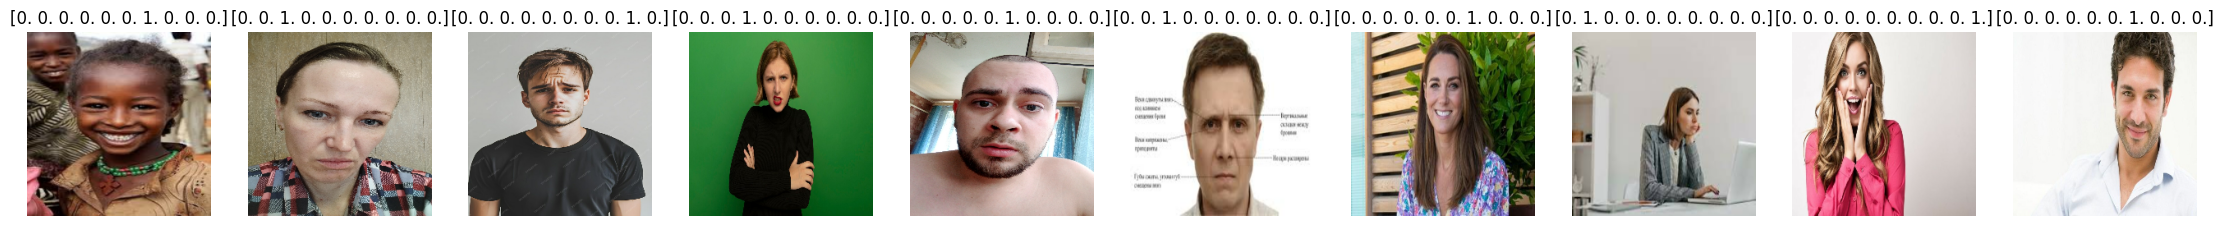

In [ ]:
def imshow():
  n = 10
  plt.figure(figsize=(28, 9))
  for images, labels in dataset.take(1):
    for i in range(n):
      img = images[i]
      temp = plt.subplot(3, n, i + 1 + n)
      plt.imshow(img, cmap='gist_gray')
      plt.axis('off')
      plt.title(str(labels.numpy()[i]))
      temp.get_yaxis().set_visible(False)
  plt.show()
imshow()

## **Импорт предобученной модели `MobileNet`.**

In [ ]:
base_model = tf.keras.applications.MobileNet(weights='imagenet',
                                            include_top=False,
                                            input_shape=(224, 224, 3))
base_model.trainable = False

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


## **Определение класса модели и её архитектуры.**

In [ ]:
@tf.keras.utils.register_keras_serializable()
class Model(tf.keras.Model):
    def __init__(self, base_model, name=None):
      super(Model, self).__init__(name=name)
      self.base_model = base_model

      # Добавляем другие слои
      self.global_average_pooling = GlobalAveragePooling2D()
      self.dense1 = Dense(512, activation='relu')
      self.batch_norm = tf.keras.layers.BatchNormalization()
      self.dropout = tf.keras.layers.Dropout(0.2)
      self.dense2 = Dense(10, activation='sigmoid')

    def get_loss(self, y, preds):
        return tf.keras.losses.CategoricalCrossentropy()(y, preds)

    @tf.function
    def training_step(self, x, y):
        with tf.GradientTape() as tape:
            preds = self.call(x)  # Вызываем call() для получения предсказаний
            loss = self.get_loss(y, preds)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return tf.reduce_mean(loss)

    def call(self, inputs, training=True):
        # Передаем данные через базовую модель и добавленные слои
        x = self.base_model(inputs, training=training)
        x = self.global_average_pooling(x)
        x = self.dense1(x)
        x = self.batch_norm(x, training=training)
        x = self.dropout(x, training=training)
        return self.dense2(x)

    def get_config(self):
        config = super().get_config()
        config['base_model'] = self.base_model.to_json()
        config['global_average_pooling'] = self.global_average_pooling.get_config()
        config['dense1'] = self.dense1.get_config()
        config['batch_norm'] = self.batch_norm.get_config()
        config['dropout'] = self.dropout.get_config()
        config['dense2'] = self.dense2.get_config()
        return config

    @classmethod
    def from_config(cls, config):
        base_model = tf.keras.models.model_from_json(config['base_model'])
        model = cls(base_model)
        model.global_average_pooling = tf.keras.layers.GlobalAveragePooling2D.from_config(config['global_average_pooling'])
        model.dense1 = Dense.from_config(config['dense1'])
        model.batch_norm = tf.keras.layers.BatchNormalization.from_config(config['batch_norm'])
        model.dropout = tf.keras.layers.Dropout.from_config(config['dropout'])
        model.dense2 = Dense.from_config(config['dense2'])
        return model

## **Компиляция модели.**

In [ ]:
model = Model(base_model)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4))

## **Шаг обучения модели.**

In [ ]:
for x, y in dataset.take(1):
  print(model.training_step(x, y))

tf.Tensor(3.1365538, shape=(), dtype=float32)


## **Обучение модели.**

Epoch 28/28, Loss: 1.6419


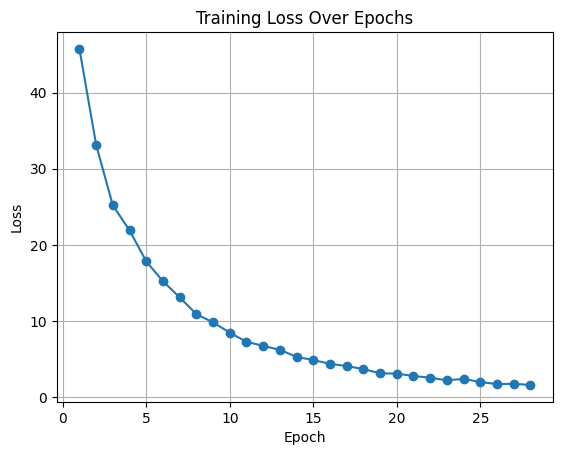

In [ ]:
from IPython.display import clear_output

# Инициализация списка для хранения значений потерь
hist = []
epochs = 28

for epoch in range(1, epochs + 1):
    total_loss = 0  # Инициализация потерь на эпоху
    for step, (x, y) in enumerate(dataset):
        total_loss += model.training_step(x, y)

    # Устранение вывода в каждой итерации
    clear_output(wait=True)
    print(f"Epoch {epoch}/{epochs}, Loss: {total_loss:.4f}")

    # Хранение потерь в списке
    hist.append(total_loss)

    # Отображение графика
    plt.plot(range(1, epoch + 1), hist, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.grid(True)
    plt.show()

## **Экспорт модели.**

In [ ]:
model.save('my_model.keras')

## **Импорт модели.**

In [ ]:
loaded_model = keras.models.load_model('my_model.keras', custom_objects={'Model': Model})

## **Тестирование работы модели и её эффективности.**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Predictions for image1.jpg: sad (Probability: 0.9923)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Predictions for image2.jpg: boredom (Probability: 0.9999)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Predictions for image3.jpg: contempt (Probability: 0.9207)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Predictions for image4.jpg: embarrassment (Probability: 0.9923)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Predictions for image6.jpg: fear (Probability: 0.9939)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Predictions for image5.jpg: fear (Probability: 0.9935)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Predictions for image7.jpg: surprised (Probability: 0.9761)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Predictions for image9.jpg: boredom (Probability: 0.9772)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Predictions for image11.jpg: neutral (Probability: 0.9150)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Predictions for image12.jpg: boredom (Probability: 0.9034)


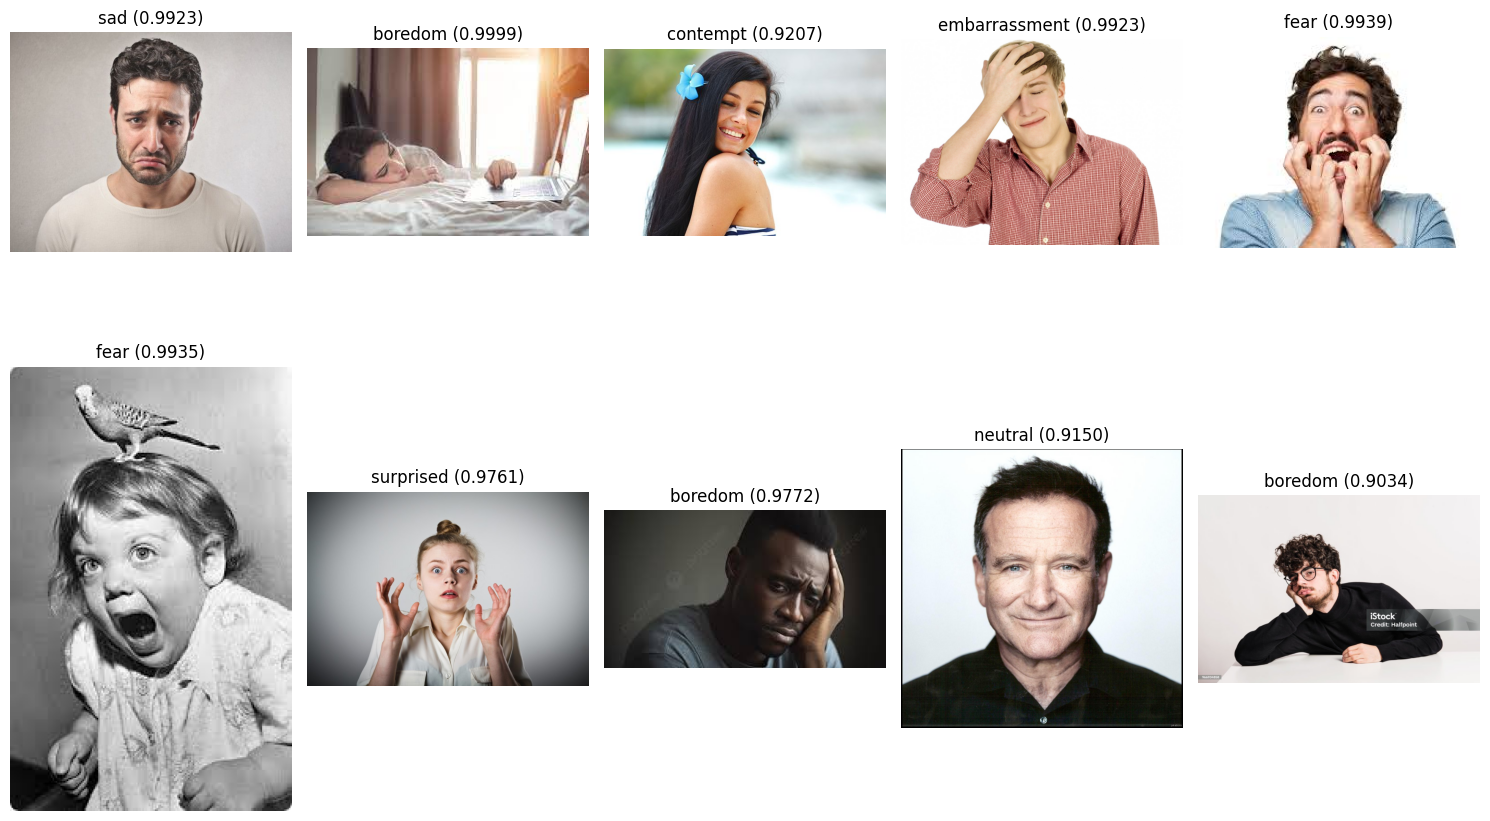

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input

# Определяем классы эмоций
class_names = ['angry', 'boredom', 'contempt', 'disgust', 'embarrassment',
               'fear', 'happy', 'neutral', 'sad', 'surprised']

# Функция для загрузки и обработки изображения
def load_and_preprocess_image(img_path):
    # Загружаем изображение
    img = image.load_img(img_path, target_size=(224, 224))
    # Преобразуем изображение в массив numpy
    img_array = image.img_to_array(img)
    # Добавляем дополнительное измерение для батча
    img_array = np.expand_dims(img_array, axis=0)
    # Применяем предобработку для MobileNetV2
    img_array = preprocess_input(img_array)

    return img_array

# Функция для тестирования модели
def test_model(model, img_paths):
    plt.figure(figsize=(15, 10))  # Устанавливаем размер графика
    for i, img_path in enumerate(img_paths):
        # Загружаем и обрабатываем изображение
        img_array = load_and_preprocess_image(img_path)
        # Получение предсказаний
        preds = model.predict(img_array)
        # Определяем индекс класса с максимальной вероятностью
        predicted_class_index = np.argmax(preds[0])
        predicted_class_name = class_names[predicted_class_index]

        # Выводим предсказания с названием класса
        print(f"Predictions for {img_path}: {predicted_class_name} (Probability: {preds[0][predicted_class_index]:.4f})")

        # Отображаем изображение
        plt.subplot(2, 5, i + 1)  # Устанавливаем расположение изображения на графике
        plt.imshow(image.load_img(img_path))  # Загружаем оригинальное изображение для отображения
        plt.title(f"{predicted_class_name} ({preds[0][predicted_class_index]:.4f})")
        plt.axis('off')  # Отключаем оси

    plt.tight_layout()  # Автоматически подстраивает размеры графиков
    plt.show()  # Показывает все изображения


test_image_paths = [
    'image1.jpg',
    'image2.jpg',
    'image3.jpg',
    'image4.jpg',
    'image6.jpg',
    'image5.jpg',
    'image7.jpg',
    'image9.jpg',
    'image11.jpg',
    'image12.jpg',
]

# Тестируем модель на изображениях
test_model(loaded_model, test_image_paths)

In [ ]:
!pip install Flask tensorflow numpy pillow

In [ ]:
!python3 app.py

2024-11-07 16:07:25.025511: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-07 16:07:25.052996: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-07 16:07:25.065299: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-07 16:07:26.656093: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
 * Serving Flask app 'app'
 * Debug mode: on
 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with stat
2024-11-07 16:07:31.763053: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT